In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
import sys
from tqdm import tqdm
import psix
import seaborn as sns
from scipy.stats import zscore
from matplotlib.gridspec import GridSpec
import subprocess as sp

cm = 1/2.54

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
1+1

2

In [4]:
psix_object = psix.Psix(psix_object = 'psix_output/psix_object/')

In [5]:
psix_object.get_cell_metric(psix_object.latent)

100%|██████████| 1067/1067 [00:00<00:00, 1959.93it/s]

Successfully computed cell-cell metric


In [6]:
meta = pd.read_csv('data/SraRunTable.txt.gz', index_col=0)
neighbors_confusion = pd.DataFrame(np.zeros((6, 6)), 
                                   index = ['embryonic day 13.5', 'embryonic day 15.5', 'embryonic day 18.5',
       'postnatal day 1', 'postnatal day 7', 'postnatal day 90'],
                                  columns = ['embryonic day 13.5', 'embryonic day 15.5', 'embryonic day 18.5',
       'postnatal day 1', 'postnatal day 7', 'postnatal day 90'])

In [7]:
e13 = 0
e15 = 0
e18 = 0
p1 = 0
p7 = 0
p90 = 0

for i in range(psix_object.metric[0].shape[0]):
    
    cell_i = psix_object.latent.iloc[psix_object.metric[0][i]].index[0]
    cell_i_neighbors = psix_object.latent.iloc[psix_object.metric[0][i]].index[1:]
    
    cell_i_type = meta.loc[cell_i].Age
    
    if cell_i_type == 'embryonic day 13.5':
        e13 += 1
    elif cell_i_type == 'embryonic day 15.5':
        e15 += 1
    elif cell_i_type == 'embryonic day 18.5':
        e18 += 1
    elif cell_i_type == 'postnatal day 1':
        p1 += 1
    elif cell_i_type == 'postnatal day 7':
        p7 += 1
    else:
        p90 += 1
    
    neighbors = meta.loc[cell_i_neighbors]
    
    neighbors_confusion.loc[cell_i_type, 'embryonic day 13.5'] += np.mean(meta.loc[cell_i_neighbors].Age == 'embryonic day 13.5')
    neighbors_confusion.loc[cell_i_type, 'embryonic day 15.5'] += np.mean(meta.loc[cell_i_neighbors].Age == 'embryonic day 15.5')
    neighbors_confusion.loc[cell_i_type, 'embryonic day 18.5'] += np.mean(meta.loc[cell_i_neighbors].Age == 'embryonic day 18.5')
    neighbors_confusion.loc[cell_i_type, 'postnatal day 1'] += np.mean(meta.loc[cell_i_neighbors].Age == 'postnatal day 1')
    neighbors_confusion.loc[cell_i_type, 'postnatal day 7'] += np.mean(meta.loc[cell_i_neighbors].Age == 'postnatal day 7')
    neighbors_confusion.loc[cell_i_type, 'postnatal day 90'] += np.mean(meta.loc[cell_i_neighbors].Age == 'postnatal day 90')
    
    
    
#     neighbors_confusion



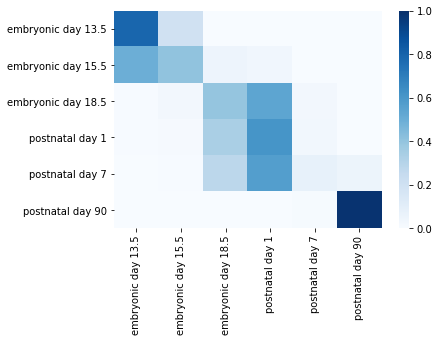

In [8]:
sns.heatmap(
    neighbors_confusion.divide(pd.Series([e13, e15, e18, p1, p7, p90], index = neighbors_confusion.index), axis=0),
    cmap='Blues', vmin=0, vmax=1
)

In [26]:
introns_tab = pd.read_csv('~/psix_project/psix/annotation/mm10_introns.tab.gz', sep='\t', index_col=0)

In [27]:
I1_tab = introns_tab.loc[[x for x in introns_tab.index if x.split('_')[-1] == 'I1']]
I2_tab = introns_tab.loc[[x for x in introns_tab.index if x.split('_')[-1] == 'I2']]

start_se = [x.split(':')[1].split('-')[1] for x in I1_tab.intron]
end_se = [x.split(':')[1].split('-')[0] for x in I2_tab.intron]
se_event = list(I1_tab.event)
chrom = [x.split(':')[0] for x in I1_tab.intron]
strand = [x.split(':')[2] for x in I1_tab.intron]

In [253]:
SE_bed = pd.DataFrame()
SE_bed['chrom'] = chrom
SE_bed['start'] = start_se
SE_bed['end'] = end_se
SE_bed['name'] = se_event

SJ_bed = pd.DataFrame()


chrom_ = []
start_ = []
end_ = []
names_ = []
strand_ = []
assert len(strand) == len(se_event)

for i in tqdm(range(len(se_event)), leave=True, position=0):
    chrom_.extend([chrom[i], chrom[i]])
    start_.append(int(start_se[i])-30)
    start_.append(int(end_se[i])-30)   
    end_.append(int(start_se[i])+30)
    end_.append(int(end_se[i])+30)
    

    if strand[i] == '+':
        names_.append(se_event[i] + '_5p')
        names_.append(se_event[i] + '_3p')
    else:
        names_.append(se_event[i] + '_3p')
        names_.append(se_event[i] + '_5p')
    
    strand_.extend([strand[i], strand[i]])
    
    
SJ_bed['chrom'] = chrom_
SJ_bed['start'] = start_
SJ_bed['end'] = end_

SJ_bed['name'] = names_
SJ_bed['score'] = np.zeros(2*len(se_event))
SJ_bed['strand'] = strand_

100%|██████████| 35732/35732 [00:00<00:00, 238588.24it/s]


In [254]:
SJ_bed

,chrom,start,end,name,score,strand
0,chr6,121662362,121662422,A2m_1_5p,0.0,+
1,chr6,121662415,121662475,A2m_1_3p,0.0,+
2,chr15,83230483,83230543,A4galt_1_3p,0.0,-
3,chr15,83230628,83230688,A4galt_1_5p,0.0,-
4,chr2,122638226,122638286,AA467197_1_5p,0.0,+
...,...,...,...,...,...,...
71459,chr7,89923686,89923746,l7Rn6_6_5p,0.0,-
71460,chr7,89930289,89930349,l7Rn6_nmdSE_1_3p,0.0,-
71461,chr7,89930431,89930491,l7Rn6_nmdSE_1_5p,0.0,-
71462,chr7,89935696,89935756,l7Rn6_nmdSE_2_3p,0.0,-


In [255]:
if not os.path.isdir('phylop/'):
    os.mkdir('phylop')
    
SE_bed.to_csv('phylop/SE.bed.gz', sep='\t', index=False, header=False)
SJ_bed.to_csv('phylop/SJ.bed.gz', sep='\t', index=False, header=False)

In [256]:
bedtools_cmd = 'bedtools intersect -wb -a ~/Genomes/Mouse/mm10/mm10.60way.phyloP60way.bed.gz -b {bed_file} > {file_phylop}'
print(bedtools_cmd.format(bed_file = 'SJ.bed.gz', file_phylop='SJ_phylop.bed'))
print(bedtools_cmd.format(bed_file = 'SE.bed.gz', file_phylop='SE_phylop.bed'))

# sp.run(bedtools_cmd.format(bed_file = 'phylop/SE.bed.gz', file_phylop='phylop/SE_phylop.bed'), shell=True)
# sp.run(bedtools_cmd.format(bed_file = 'phylop/SJ.bed.gz', file_phylop='phylop/SJ_phylop.bed'), shell=True)

bedtools intersect -wb -a ~/Genomes/Mouse/mm10/mm10.60way.phyloP60way.bed.gz -b SJ.bed.gz > SJ_phylop.bed
bedtools intersect -wb -a ~/Genomes/Mouse/mm10/mm10.60way.phyloP60way.bed.gz -b SE.bed.gz > SE_phylop.bed


In [9]:
SE_phylop = pd.read_csv('phylop/SJ_phylop.bed', names=['chrom', 'bp_start', 'bp_end', 'phylop_id', 'score',
                                                         'chrom_', 'exon_start', 'exon_end', 'exon_name', 'score_',
                                                      'strand'], sep='\t')

In [10]:
exon_phylop = SE_phylop.groupby('exon_name').score.mean()

In [44]:
sig_exons = psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index

pos_exons = psix_object.psix_results.loc[
    (psix_object.psix_results.qvals >= 0.05) & (psix_object.psix_results.psix_score > 0)].index

non_sig_exons = psix_object.psix_results.loc[
    (psix_object.psix_results.qvals >= 0.05) & (psix_object.psix_results.psix_score < 0)].index

idx = []
for exon in psix_object.psix_results.index:
    idx_5p = SE_phylop.loc[SE_phylop.exon_name == exon + '_5p'].index
    idx_3p = SE_phylop.loc[SE_phylop.exon_name == exon + '_3p'].index
    
    idx.extend(list(idx_5p) + list(idx_3p))
    
SE_phylop_filtered = SE_phylop.loc[idx].shape

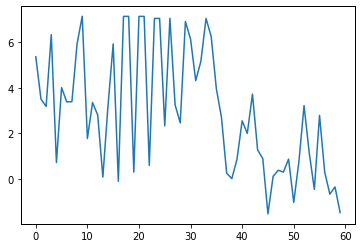

In [12]:
plt.plot(range(60), SE_phylop.loc[SE_phylop.exon_name == 'Mapt_1_3p'].score)

In [32]:
counts_ = 0
suma_ = np.array(np.zeros(120))

for exon in tqdm(non_sig_exons):
    try:
        slice_exon_5p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_5p']
        slice_exon_3p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)
            score_3p = list(slice_exon_3p.score)
        else:
            score_5p = list(slice_exon_5p.score)[::-1]
            score_3p = list(slice_exon_3p.score)[::-1]



        suma_ += np.array(score_5p + score_3p)
        counts_ += 1
    except:
        continue

counts = 0
suma = np.array(np.zeros(120))

for exon in tqdm(sig_exons):
    try:
        slice_exon_5p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_5p']
        slice_exon_3p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)
            score_3p = list(slice_exon_3p.score)
        else:
            score_5p = list(slice_exon_5p.score)[::-1]
            score_3p = list(slice_exon_3p.score)[::-1]



        suma += np.array(score_5p + score_3p)
        counts += 1
    except:
        continue


100%|██████████| 1289/1289 [00:38<00:00, 33.65it/s]


In [29]:
counts = 0
suma = np.array(np.zeros(120))

for exon in tqdm(sig_exons):
    try:
        slice_exon_5p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_5p']
        slice_exon_3p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)
            score_3p = list(slice_exon_3p.score)
        else:
            score_5p = list(slice_exon_5p.score)[::-1]
            score_3p = list(slice_exon_3p.score)[::-1]



        suma += np.array(score_5p + score_3p)
        counts += 1
    except:
        continue


100%|██████████| 798/798 [00:00<00:00, 579676.93it/s]


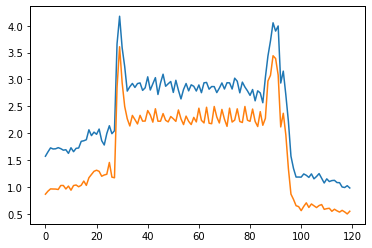

In [35]:
plt.plot(range(120), np.array(suma)/counts)
plt.plot(range(120), np.array(suma_)/counts_)

In [51]:
mean_phylop_5p = []
mean_phylop_3p = []

counts_sig = 0
for exon in tqdm(sig_exons):
    try:
        slice_exon_5p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_5p']
        slice_exon_3p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)[20:40]
            score_3p = list(slice_exon_3p.score)[20:40]
        else:
            score_5p = list(slice_exon_5p.score)[::-1][20:40]
            score_3p = list(slice_exon_3p.score)[::-1][20:40]

        mean_phylop_5p.append(np.mean(score_5p))
        mean_phylop_3p.append(np.mean(score_3p))
        counts_sig += 1
    except:
        continue
        
counts_pos = 0
for exon in tqdm(pos_exons):
    try:
        slice_exon_5p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_5p']
        slice_exon_3p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)[20:40]
            score_3p = list(slice_exon_3p.score)[20:40]
        else:
            score_5p = list(slice_exon_5p.score)[::-1][20:40]
            score_3p = list(slice_exon_3p.score)[::-1][20:40]

        mean_phylop_5p.append(np.mean(score_5p))
        mean_phylop_3p.append(np.mean(score_3p))
        counts_pos += 1
    except:
        continue


counts_non_sig = 0
for exon in tqdm(non_sig_exons):
    try:
        slice_exon_5p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_5p']
        slice_exon_3p = SE_phylop_filtered.loc[SE_phylop_filtered.exon_name == exon + '_3p']

        if slice_exon_5p.strand.iloc[0] == '+':
            score_5p = list(slice_exon_5p.score)[20:40]
            score_3p = list(slice_exon_3p.score)[20:40]
        else:
            score_5p = list(slice_exon_5p.score)[::-1][20:40]
            score_3p = list(slice_exon_3p.score)[::-1][20:40]

        mean_phylop_5p.append(np.mean(score_5p))
        mean_phylop_3p.append(np.mean(score_3p))
        counts_non_sig += 1
    except:
        continue


100%|██████████| 812/812 [00:24<00:00, 33.37it/s]


In [52]:
scores_df = pd.DataFrame()
scores_df['exon type'] = (['significant']*counts_sig) + (['positive non sig']*counts_pos) + (['non significant']*counts_non_sig)
scores_df["score 5'"] = mean_phylop_5p
scores_df["score 3'"] = mean_phylop_3p

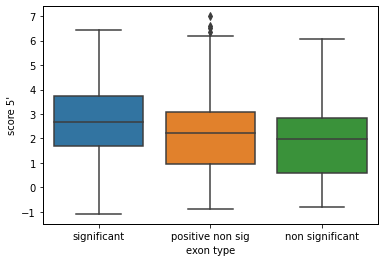

In [53]:
sns.boxplot(x='exon type', y="score 5'", data=scores_df)

In [ ]:
SE_phylio

In [241]:
suma_ = np.array(np.zeros(60))

for exon in tqdm(non_sig_exons):
    try:
        slice_exon = SE_phylop.loc[SE_phylop.exon_name == exon].score
        suma_ += np.array(slice_exon[:60])
        suma_ += np.array(slice_exon[60:])
    except:
        continue


100%|██████████| 1289/1289 [05:12<00:00,  4.12it/s]


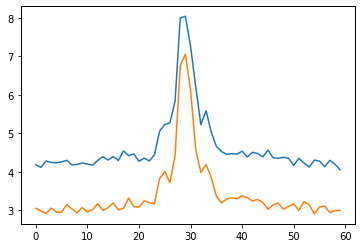

In [242]:
plt.plot(range(60), suma/798)
plt.plot(range(60), suma_/1289)

In [216]:
exon_phylop.loc[exon_phylop.index & psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index].median()

2.252608333333332

In [217]:
exon_phylop.loc[exon_phylop.index & psix_object.psix_results.loc[
    (psix_object.psix_results.qvals >= 0.05) & (psix_object.psix_results.psix_score > 0)].index].median()

1.8178458333333327

In [218]:
exon_phylop.loc[exon_phylop.index & psix_object.psix_results.loc[
    (psix_object.psix_results.qvals >= 0.05) & (psix_object.psix_results.psix_score <= 0)].index].median()

1.6728333333333338

In [219]:
from scipy.stats import ranksums

ranksums(exon_phylop.loc[exon_phylop.index & psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index], 
        exon_phylop.loc[exon_phylop.index & psix_object.psix_results.loc[psix_object.psix_results.qvals >= 0.05].index])

RanksumsResult(statistic=9.908297714904108, pvalue=3.831179367548154e-23)

(array([0.10498356, 0.32287397, 0.19610137, 0.29712329, 0.33872055,
        0.1624274 , 0.10300274, 0.03763562, 0.02773151, 0.01188493]),
 array([-0.59894167,  0.02508917,  0.64912   ,  1.27315083,  1.89718167,
         2.5212125 ,  3.14524333,  3.76927417,  4.393305  ,  5.01733583,
         5.64136667]),
 <a list of 10 Patch objects>)

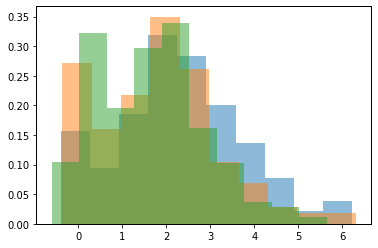

In [220]:
plt.hist(exon_phylop.loc[exon_phylop.index & psix_object.psix_results.loc[psix_object.psix_results.qvals <= 0.05].index],
        alpha=0.5, density=True)
plt.hist(exon_phylop.loc[exon_phylop.index & psix_object.psix_results.loc[
 (psix_object.psix_results.qvals >= 0.05) & (psix_object.psix_results.psix_score > 0)].index],
        alpha=0.5, density=True)
plt.hist(exon_phylop.loc[exon_phylop.index & psix_object.psix_results.loc[
 (psix_object.psix_results.qvals >= 0.05) & (psix_object.psix_results.psix_score <= 0)].index],
        alpha=0.5, density=True)

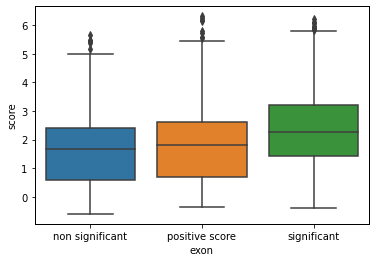

In [221]:
scores_df = pd.DataFrame(index=exon_phylop.loc[exon_phylop.index & psix_object.psix_results.index].index)
scores_df['score'] = list(exon_phylop.loc[exon_phylop.index & psix_object.psix_results.index])

significance = []
for idx in scores_df.index:
    if (psix_object.psix_results.loc[idx, 'psix_score'] > 0) and (psix_object.psix_results.loc[idx, 'qvals'] <= 0.05):
        significance.append('significant')
    elif (psix_object.psix_results.loc[idx, 'psix_score'] > 0) and (psix_object.psix_results.loc[idx, 'qvals'] >= 0.05):
        significance.append('positive score')
    else:
        significance.append('non significant')
        
scores_df['exon'] = significance
sns.boxplot(x='exon', y='score', data=scores_df)

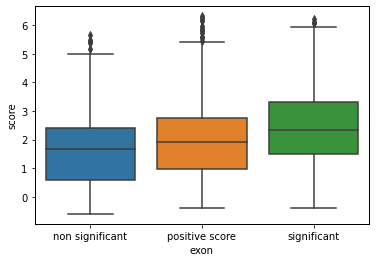

In [213]:
scores_df = pd.DataFrame(index=exon_phylop.loc[exon_phylop.index & psix_object.psix_results.index].index)
scores_df['score'] = list(exon_phylop.loc[exon_phylop.index & psix_object.psix_results.index])

significance = []
for idx in scores_df.index:
    if (psix_object.psix_results.loc[idx, 'psix_score'] > 0) and (psix_object.psix_results.loc[idx, 'qvals'] <= 0.01):
        significance.append('significant')
    elif (psix_object.psix_results.loc[idx, 'psix_score'] > 0) and (psix_object.psix_results.loc[idx, 'qvals'] <= 0.5):
        significance.append('positive score')
    else:
        significance.append('non significant')
        
scores_df['exon'] = significance
sns.boxplot(x='exon', y='score', data=scores_df)

In [144]:
from scipy.stats import pearsonr, spearmanr

In [147]:
pearsonr(exon_phylop.loc[exon_phylop.index & psix_object.psix_results.index],
            psix_object.psix_results.loc[exon_phylop.index & psix_object.psix_results.index].psix_score)

(0.16564104566949212, 2.865501519460472e-14)

In [179]:
exon_phylop.loc[exon_phylop.index & psix_object.psix_results.index]

Aamdc_10         3.247402
Aamdc_9          0.054352
Aasdhppt_2       3.170854
Abat_3           4.013237
Abca3_4         -0.057189
                   ...   
Zscan18_1        0.693537
Zyx_1            2.238532
l7Rn6_1          4.025937
l7Rn6_3          0.195815
l7Rn6_nmdSE_1    1.825606
Name: score, Length: 2081, dtype: float64

# Expression modules

In [80]:
norm_tpm = pd.read_csv('data/preprocess/scone_norm_tpm.tab.gz', sep='\t', index_col=0)[psix_object.latent.index]

In [81]:
norm_tpm

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
Gnai3,4.486,4.717,5.407,5.600,5.442,5.110,5.683,0.000,4.633,5.754,...,0.366,0.000,2.981,0.000,0.086,0.000,3.843,3.820,0.000,1.987
Narf,6.379,3.981,4.593,5.429,3.327,4.999,4.878,5.404,4.803,4.590,...,0.000,5.193,3.142,0.000,3.216,4.246,5.380,2.244,0.121,0.451
Cav2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.609,0.000,0.000,0.000,4.149,2.229,3.491,1.885,1.455,1.737
Klf6,1.339,3.973,3.061,0.000,0.000,3.828,1.769,3.247,0.000,0.000,...,2.920,4.798,4.916,2.299,0.259,3.326,0.524,3.467,4.166,2.748
Scmh1,4.895,4.482,2.667,2.412,6.262,0.000,0.000,0.000,0.000,0.000,...,3.011,4.807,2.774,3.441,0.836,3.683,3.484,4.863,4.482,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Igip,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,3.877,4.934,1.229,0.000,0.908,1.311,2.550,1.847,3.223,3.933
Pde2a,0.000,0.000,0.000,0.000,0.000,1.965,0.000,1.702,0.000,0.000,...,0.000,4.045,3.879,0.000,0.000,0.000,0.000,2.140,0.000,0.000
Gm45799,0.000,3.482,0.000,0.000,2.585,0.000,4.273,2.821,0.000,0.000,...,3.896,0.000,2.541,0.000,0.878,2.693,4.213,4.091,0.739,1.108
Nudc-ps1,4.002,0.000,0.000,3.373,3.315,0.000,0.000,3.189,3.123,3.826,...,0.000,0.000,1.447,2.961,0.000,0.964,3.483,0.000,0.000,2.442


In [128]:
mod1_genes = zscore(norm_tpm.loc[set([x.split('_')[0] for x in psix_object.modules.loc[psix_object.modules == 1].index])], 
                    axis=1).mean(axis=0)

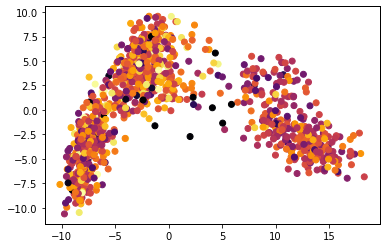

In [129]:
plt.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2,
           c=mod1_genes, cmap='inferno', vmin=np.quantile(mod1_genes, 0.01), 
            vmax=np.quantile(mod1_genes, 0.99))

In [226]:
def plot_module_genes(mod):
    
    genes = pd.Index(set([x.split('_')[0] for x in psix_object.modules.loc[psix_object.modules == mod].index]))
    
    
    
    mod1_genes = norm_tpm.index.intersection(genes)

    mod1_genes = zscore(expression_avg.loc[mod1_genes], axis=1).mean(axis=0)


    plt.tight_layout()
    fig = plt.figure(figsize=(9*cm, 6.75*cm))
    ax = fig.add_subplot(111, projection='3d')

    ax.grid(False)
    ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2, psix_object.latent.PC_3,
               c=mod1_genes, s=10, linewidth=0, alpha=0.8, cmap='inferno', vmin=-1, vmax=1)
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
    ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
    ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
    ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)

    ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
    ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
    ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

<Figure size 432x288 with 0 Axes>

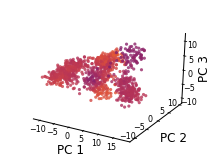

In [229]:
plot_module_genes(1)

In [151]:
def get_exon_neighbors_psi(observed_psi_array, cell_metric):
    psi_a_array = []
    for i in range(len(observed_psi_array)):

        neighbors = cell_metric[0][i]
        weights = cell_metric[1][i]

        psi_sum = 0
        weight_sum = 0
        for j in range(len(neighbors)):
            psi_n = observed_psi_array[neighbors[j]]
#             print(psi_n)
            if not np.isnan(psi_n):
                psi_sum += (psi_n * weights[j])
                weight_sum += weights[j]
        if weight_sum > 0:
            psi_a_array.append(psi_sum/weight_sum)
        else:
            psi_a_array.append(np.nan)
                
    return psi_a_array


def get_all_exons_neighbors(psi, cell_metric):
    
    neighbors_psi = []
    
    for exon_psi in psi.T:
        neighbors_psi.append(get_exon_neighbors_psi(exon_psi, cell_metric))
        
    return np.array(neighbors_psi)


def get_background(self):
    psi = np.array(self.adata.uns['psi'])
    
    neighbors_psi = pd.DataFrame(get_all_exons_neighbors(psi, self.metric),
                                 columns = self.adata.uns['psi'].index,
                                 index = self.adata.uns['psi'].columns)
    self.adata.uns['neighbors_psi'] = neighbors_psi.T
    

In [183]:
module_genes = norm_tpm.index.intersection(
    pd.Index(set([x.split('_')[0] for x in psix_object.modules.index]))
)

In [184]:
expression_avg = get_all_exons_neighbors(
    np.array(norm_tpm.loc[module_genes, 
                          psix_object.latent.index].T), 
    psix_object.metric
)

In [185]:
expression_avg = pd.DataFrame(expression_avg, index = module_genes, columns = psix_object.latent.index)

<Figure size 432x288 with 0 Axes>

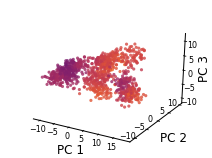

In [241]:
plot_module_genes(10)

In [173]:
def plot_module_genes(mod):
    
    genes = pd.Index(set([x.split('_')[0] for x in psix_object.modules.loc[psix_object.modules == mod].index]))
    
    
    
    mod1_genes = expression_avg.index.intersection(genes)

    mod1_genes = zscore(expression_avg.loc[mod1_genes], axis=1).mean(axis=0)


    plt.tight_layout()
    fig = plt.figure(figsize=(9*cm, 6.75*cm))
    ax = fig.add_subplot(111, projection='3d')

    ax.grid(False)
    ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2, psix_object.latent.PC_3,
               c=mod1_genes, s=10, linewidth=0, alpha=0.8, cmap='inferno', vmin=np.quantile(mod1_genes, 0.05), 
                vmax=np.quantile(mod1_genes, 0.95))
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
    ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
    ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
    ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)

    ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
    ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
    ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

In [187]:
expression_avg

,SRR7408400,SRR7408401,SRR7408404,SRR7408413,SRR7408414,SRR7408418,SRR7408422,SRR7408424,SRR7408426,SRR7408427,...,SRR7410086,SRR7410088,SRR7410089,SRR7410090,SRR7410091,SRR7410092,SRR7410093,SRR7410094,SRR7410096,SRR7410097
Comt,3.595100,3.437016,3.606106,3.722785,3.684443,3.446992,3.554220,3.393291,3.437120,3.572446,...,4.700421,4.360451,4.449894,4.839438,4.711846,4.502913,4.631301,4.499248,4.649553,4.503980
Tom1l2,2.714482,2.702245,2.609978,2.644721,2.631619,2.648682,2.613407,2.480305,2.711409,2.567705,...,3.673922,3.776179,3.791360,3.727906,3.663327,3.759312,3.756955,3.808053,3.653387,3.694458
Hnrnpd,2.473683,2.449222,2.634058,2.421028,2.533911,2.687159,2.787390,2.788724,2.611390,2.737577,...,1.994121,1.914678,1.833667,1.826543,2.066265,1.820645,2.162991,1.826880,2.130866,2.127446
Sez6,4.399221,4.590285,4.703922,4.680828,4.677982,4.693247,4.772253,3.658779,4.136902,4.688798,...,3.355164,2.584084,2.409737,4.070649,3.509817,2.431479,4.404923,2.258774,4.229579,3.470184
Dnajc5,4.206534,3.995207,3.883421,3.863621,3.848039,3.930985,3.889135,4.255992,4.149425,3.866627,...,4.622874,4.355701,4.384269,4.587978,4.582604,4.330234,4.492671,4.391753,4.475362,4.476202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kantr,1.890385,1.343733,1.697726,1.462042,1.668540,1.593473,1.547458,2.049687,1.923650,1.787217,...,4.527640,4.491254,4.573348,4.585767,4.537234,4.647400,4.390470,4.621386,4.355163,4.688616
Mettl23,2.881241,2.940856,2.945743,3.024156,2.932933,2.914088,2.873098,3.016532,2.818449,2.937890,...,1.736887,1.883390,1.842630,1.671373,1.783440,1.908677,1.844999,1.870100,1.843432,1.707789
Lsm5,2.580747,2.725359,2.913336,2.953963,2.884194,2.774292,2.944647,2.634734,2.487930,2.913534,...,2.038639,2.585448,2.647294,1.934454,2.093073,2.697434,2.183102,2.637645,1.987416,2.183934
Rbm4,3.787354,3.892046,4.182145,4.014779,4.033720,4.074104,4.119416,3.735122,3.706645,4.178448,...,2.375578,2.005350,2.034916,2.460227,2.392471,2.070444,2.454091,2.058737,2.483540,2.388428


In [186]:

def local_correlation_plot(local_correlation_z, modules, linkage,
                           z_cmap='RdBu_r', yticklabels=False,
                           plot_name = ''):
    
    row_colors = None
    colors = list(plt.get_cmap('tab10').colors)
    
    ii = leaves_list(linkage)

    mod_reordered = modules.iloc[ii]
    
    
    col_idx = {}
    
    
    counter = 0
    for i in mod_reordered:
        
        if (i not in col_idx.keys()) and (i != -1):
            col_idx.update({i:counter})
            counter += 1

    module_colors = {i: colors[(col_idx[i]) % len(colors)] for i in col_idx.keys()}
    module_colors[-1] = '#ffffff'

    row_colors1 = pd.Series(
        [module_colors[i] for i in modules],
        index=local_correlation_z.index,
    )

    row_colors = pd.DataFrame({
        "Modules": row_colors1,
    })
    
    
    if plot_name != '':
        figsize = (8/2.4, 9/2.4)
        fontsize = 8
        
    else:
        figsize = (8.4, 9)
        fontsize=20
    
    cm = sns.clustermap(
        local_correlation_z,
        row_linkage=linkage,
        col_linkage=linkage,
        vmin=-1,
        vmax=1,
        cmap=z_cmap,
        xticklabels=False,
        yticklabels=yticklabels,
        row_colors=row_colors,
        rasterized=True,
        figsize=figsize
    )

    fig = plt.gcf()
    plt.sca(cm.ax_heatmap)
    plt.ylabel("")
    plt.xlabel("")

    cm.ax_row_dendrogram.remove()

    mod_map = {}
    y = np.arange(modules.size)

    for x in mod_reordered.unique():
        if x == -1:
            continue

        mod_map[x] = y[mod_reordered == x].mean()

    plt.sca(cm.ax_row_colors)
    
    mod_relabeled = pd.DataFrame()
    mod_idx = []
    mod_labels = []
    i = 1
    for mod, mod_y in mod_map.items():
        
        if int(mod) != -1:
            plt.text(-.25, y=mod_y, s="Mod {}".format(str(i)),
                     horizontalalignment='right',
                     verticalalignment='center', fontsize=fontsize)

            exon_list = list(mod_reordered.loc[mod_reordered == int(mod)].index)
            mod_idx.extend(exon_list)
            mod_labels.extend([i]*len(exon_list))
            i += 1
        
    exon_list = list(mod_reordered.loc[mod_reordered == -1].index)
    mod_idx.extend(exon_list)
    mod_labels.extend([-1]*len(exon_list))
        
    mod_relabeled['Modules'] = mod_labels
    mod_relabeled.index = mod_idx
        
                 
#         plt.text(-.25, y=mod_y, s="Mod {}".format(mod),
#                  horizontalalignment='right',
#                  verticalalignment='center', fontsize=fontsize)
        
    plt.xticks([])

    min_delta = 1e99
    min_aa = None
    for aa in fig.get_children():
        try:
            bbox = aa.get_position()
            delta = (0-bbox.xmin-2)**2 + (1-bbox.ymax)**2
            if delta < min_delta:
                delta = min_delta
                min_aa = aa
        except AttributeError:
            pass

    min_aa.set_ylabel('Pearson r', fontsize=fontsize)
    min_aa.yaxis.set_label_position("left")
    
    min_aa.tick_params(axis='y',labelsize=fontsize, length=0, direction="in", pad=0)
    
    if plot_name == '':
        plt.show()
    else:
        plt.savefig(plot_name, bbox_inches='tight', res=20000, dpi =2000)
    
    return mod_relabeled.Modules#mod_reordered


def sort_linkage(Z, node_index, node_values):
    """
    Sorts linkage by 'node_values' in place
    """

    N = Z.shape[0] + 1  # number of leaves

    if node_index < 0:
        return

    left_child = int(Z[node_index, 0] - N)
    right_child = int(Z[node_index, 1] - N)

    swap = False

    if left_child < 0 and right_child < 0:
        swap = False
    elif left_child < 0 and right_child >= 0:
        swap = True
    elif left_child >= 0 and right_child < 0:
        swap = False
    else:
        if node_values[left_child] > node_values[right_child]:
            swap = True
        else:
            swap = False

    if swap:
        Z[node_index, 0] = right_child + N
        Z[node_index, 1] = left_child + N

    sort_linkage(Z, left_child, node_values)
    sort_linkage(Z, right_child, node_values)


def calc_mean_dists(Z, node_index, out_mean_dists):
    """
    Calculates the mean density of joins
    for sub-trees underneath each node
    """

    N = Z.shape[0] + 1  # number of leaves

    left_child = int(Z[node_index, 0] - N)
    right_child = int(Z[node_index, 1] - N)

    if left_child < 0:
        left_average = 0
        left_merges = 0
    else:
        left_average, left_merges = calc_mean_dists(
            Z, left_child, out_mean_dists
        )

    if right_child < 0:
        right_average = 0
        right_merges = 0
    else:
        right_average, right_merges = calc_mean_dists(
            Z, right_child, out_mean_dists
        )

    this_height = Z[node_index, 2]
    this_merges = left_merges + right_merges + 1
    this_average = (
        left_average * left_merges + right_average * right_merges + this_height
    ) / this_merges

    out_mean_dists[node_index] = this_average

    return this_average, this_merges


def prop_label(Z, node_index, label, labels, out_clusters):
    """
    Propagates node labels downward if they are not -1
    Used to find the correct cluster label at the leaves
    """

    N = Z.shape[0] + 1  # number of leaves

    if label == -1:
        label = labels[node_index]

    left_child = int(Z[node_index, 0] - N)
    right_child = int(Z[node_index, 1] - N)

    if left_child < 0:
        out_clusters[left_child + N] = label
    else:
        prop_label(Z, left_child, label, labels, out_clusters)

    if right_child < 0:
        out_clusters[right_child + N] = label
    else:
        prop_label(Z, right_child, label, labels, out_clusters)


def prop_label2(Z, node_index, label, labels, out_clusters):
    """
    Propagates node labels downward
    Helper method used in assign_modules
    """

    N = Z.shape[0] + 1  # number of leaves

    parent_label = label
    this_label = labels[node_index]

    if this_label == -1:
        new_label = parent_label
    else:
        new_label = this_label

    left_child = int(Z[node_index, 0] - N)
    right_child = int(Z[node_index, 1] - N)

    if left_child < 0:
        out_clusters[left_child + N] = new_label
    else:
        prop_label2(Z, left_child, new_label, labels, out_clusters)

    if right_child < 0:
        out_clusters[right_child + N] = new_label
    else:
        prop_label2(Z, right_child, new_label, labels, out_clusters)


def assign_modules(Z, leaf_labels, offset, MIN_THRESHOLD=10, Z_THRESHOLD=3):
    clust_i = 0

    labels = np.ones(Z.shape[0])*-1
    N = Z.shape[0]+1

    mean_dists = np.zeros(Z.shape[0])
    calc_mean_dists(Z, Z.shape[0]-1, mean_dists)

    for i in range(Z.shape[0]):

        ca = int(Z[i, 0])
        cb = int(Z[i, 1])

        if ca - N < 0:  # leaf node
            n_members_a = 1
            clust_a = -1
        else:
            n_members_a = Z[ca-N, 3]
            clust_a = labels[ca-N]

        if cb - N < 0:  # leaf node
            n_members_b = 1
            clust_b = -1
        else:
            n_members_b = Z[cb-N, 3]
            clust_b = labels[cb-N]

        if Z[i, 2] > offset - Z_THRESHOLD:
            new_clust_assign = -1
        elif (n_members_a >= MIN_THRESHOLD and n_members_b >= MIN_THRESHOLD):
            # don't join them
            # assign the one with the larger mean distance
            dist_a = mean_dists[ca-N]
            dist_b = mean_dists[cb-N]
            if dist_a >= dist_b:
                new_clust_assign = clust_a
            else:
                new_clust_assign = clust_b
        elif n_members_a >= MIN_THRESHOLD:
            new_clust_assign = clust_a
        elif n_members_b >= MIN_THRESHOLD:
            new_clust_assign = clust_b
        elif (n_members_b + n_members_a) >= MIN_THRESHOLD:
            # A new cluster is born!
            new_clust_assign = clust_i
            clust_i += 1
        else:
            new_clust_assign = -1  # Still too small

        labels[i] = new_clust_assign

    out_clusters = np.ones(N)*-2
    prop_label2(Z, Z.shape[0]-1, labels[-1], labels, out_clusters)

    # remap out_clusters
    unique_clusters = list(np.sort(np.unique(out_clusters)))

    if -1 in unique_clusters:
        unique_clusters.remove(-1)

    clust_map = {
        x: i+1 for i, x in enumerate(unique_clusters)
    }
    clust_map[-1] = -1

    out_clusters = [clust_map[x] for x in out_clusters]
    out_clusters = pd.Series(out_clusters, index=leaf_labels)

    return out_clusters


def assign_modules_core(Z, leaf_labels, offset, MIN_THRESHOLD=10, Z_THRESHOLD=3):
    clust_i = 0

    labels = np.ones(Z.shape[0])*-1
    N = Z.shape[0]+1

    for i in range(Z.shape[0]):

        ca = int(Z[i, 0])
        cb = int(Z[i, 1])

        if ca - N < 0:  # leaf node
            n_members_a = 1
            clust_a = -1
        else:
            n_members_a = Z[ca-N, 3]
            clust_a = labels[ca-N]

        if cb - N < 0:  # leaf node
            n_members_b = 1
            clust_b = -1
        else:
            n_members_b = Z[cb-N, 3]
            clust_b = labels[cb-N]

        if (n_members_a >= MIN_THRESHOLD and n_members_b >= MIN_THRESHOLD):
            # don't join them
            new_clust_assign = -1
        elif Z[i, 2] > offset - Z_THRESHOLD:
            new_clust_assign = -1
        elif n_members_a >= MIN_THRESHOLD:
            new_clust_assign = clust_a
        elif n_members_b >= MIN_THRESHOLD:
            new_clust_assign = clust_b
        elif (n_members_b + n_members_a) >= MIN_THRESHOLD:
            # A new cluster is born!
            new_clust_assign = clust_i
            clust_i += 1
        else:
            new_clust_assign = -1  # Still too small

        labels[i] = new_clust_assign

    out_clusters = np.ones(N)*-2
    prop_label(Z, Z.shape[0]-1, labels[-1], labels, out_clusters)

    # remap out_clusters
    unique_clusters = list(np.sort(np.unique(out_clusters)))

    if -1 in unique_clusters:
        unique_clusters.remove(-1)

    clust_map = {
        x: i+1 for i, x in enumerate(unique_clusters)
    }
    clust_map[-1] = -1

    out_clusters = [clust_map[x] for x in out_clusters]
    out_clusters = pd.Series(out_clusters, index=leaf_labels)

    return out_clusters


def compute_modules_function(exon_correlation, min_gene_threshold=30, fdr_threshold=None, z_threshold=None, core_only=False):
    """
    Assigns modules from the gene pair-wise Z-scores
    Parameters
    ----------
    exon_correlation: pandas.DataFrame
        local correlations between genes
    min_gene_threshold: int, optional
        minimum number of genes to create a module
    fdr_threshold: float, optional
        used to determine minimally significant z_score
    core_only: bool, optional
        whether or not to assign unassigned genes to a module
    Returns
    -------
    modules: pandas.Series
        maps gene id to module id
    linkage: numpy.ndarray
        Linkage matrix in the format used by scipy.cluster.hierarchy.linkage
    """

    # Determine Z_Threshold from FDR threshold

    if z_threshold is None:
        allZ = squareform(  # just in case slightly not symmetric
            exon_correlation.values/2 + exon_correlation.values.T/2
        )
        allZ = np.sort(allZ)
        allP = norm.sf(allZ)
        allP_c = multipletests(allP, method='fdr_bh')[1]
        ii = np.nonzero(allP_c < fdr_threshold)[0]
        if ii.size > 0:
            z_threshold = allZ[ii[0]]
        else:
            z_threshold = allZ[-1]+1

    # Compute the linkage matrix
    dd = np.array(exon_correlation.copy())#.values
    np.fill_diagonal(dd, 0)
    condensed = squareform(dd)*-1
    offset = condensed.min() * -1
    condensed += offset
    Z = linkage(condensed, method='average')
    
    # Linkage -> Modules
    if core_only:
        out_clusters = assign_modules_core(
            Z, offset=offset, MIN_THRESHOLD=min_gene_threshold,
            leaf_labels=exon_correlation.index, Z_THRESHOLD=z_threshold)
    else:
        out_clusters = assign_modules(
            Z, offset=offset, MIN_THRESHOLD=min_gene_threshold,
            leaf_labels=exon_correlation.index, Z_THRESHOLD=z_threshold)

    # Sort the leaves of the linkage matrix (for plotting)
    mean_dists = np.zeros(Z.shape[0])
    calc_mean_dists(Z, Z.shape[0]-1, mean_dists)
    linkage_out = Z.copy()
    sort_linkage(linkage_out, Z.shape[0]-1, mean_dists)

    out_clusters.name = 'Module'

    return out_clusters, linkage_out



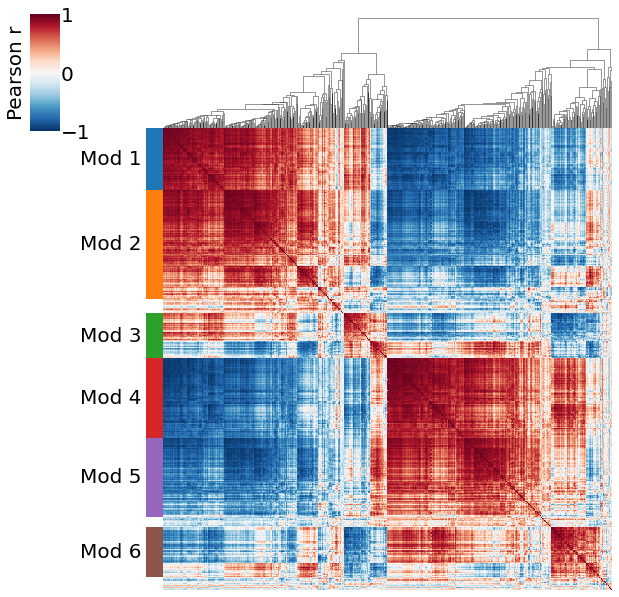

In [190]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit, logit, comb
from tqdm import tqdm
import seaborn as sns
import os
cm = 1/2.54
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.stats import zscore

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'


mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42
import sys

from scipy.cluster.hierarchy import leaves_list

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

gene_correlation = expression_avg.mask(expression_avg.isna()).T.corr().fillna(0)

gene_modules, gene_linkage = compute_modules_function(gene_correlation,min_gene_threshold=30, 
                                     fdr_threshold=None, z_threshold=0.3, core_only=False)
        
gene_modules = local_correlation_plot(gene_correlation, gene_modules, gene_linkage,
                            z_cmap='RdBu_r', yticklabels=False, plot_name = '')

In [191]:
gene_modules

Smarca4    1
Rbfox2     1
Smarcc2    1
Ank3       1
Vangl2     1
          ..
Fbxw11    -1
Ppp3ca    -1
Fam3a     -1
Pcbp2     -1
Cpne1     -1
Name: Modules, Length: 588, dtype: int64

In [230]:
def plot_gene_module_genes(mod):
    
    genes = gene_modules.loc[gene_modules == mod].index
    
    
    
    mod1_genes = expression_avg.index.intersection(genes)

    mod1_genes = zscore(expression_avg.loc[mod1_genes], axis=1).mean(axis=0)


    plt.tight_layout()
    fig = plt.figure(figsize=(9*cm, 6.75*cm))
    ax = fig.add_subplot(111, projection='3d')

    ax.grid(False)
    ax.scatter(psix_object.latent.PC_1, psix_object.latent.PC_2, psix_object.latent.PC_3,
               c=mod1_genes, s=10, linewidth=0, alpha=0.8, cmap='inferno', vmin=-1, vmax=1)
    ax.set_yticks([-10, -5, 0, 5, 10])
    ax.tick_params(labelsize=8, length=5)#, direction="in", pad=-22)
    ax.tick_params(axis='y',labelsize=8, length=5, direction="in", pad=-15)
    ax.tick_params(axis='x',labelsize=8, length=5, direction="out", pad=-5)
    ax.tick_params(axis='z',labelsize=8, length=5, direction="out", pad=-4)

    ax.set_xlabel('PC 1', fontsize=12,labelpad=-5)
    ax.set_ylabel('PC 2', fontsize=12,labelpad=-5)
    ax.set_zlabel('PC 3', fontsize=12,labelpad=-8, rotation=90)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

<Figure size 432x288 with 0 Axes>

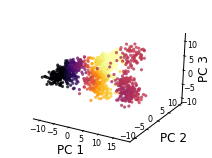

In [237]:
plot_gene_module_genes(6)

In [246]:
modules_df = pd.DataFrame(np.zeros((10, 6)),
                         index = ['exon_mod' + str(i+1) for i in range(10)],
                         columns = ['gene_mod' + str(i+1) for i in range(6)])

In [269]:
for i in range(1, 11):
    mod_genes = pd.Index(set([x.split('_')[0] for x in psix_object.modules.loc[psix_object.modules == i].index]))
    mod_genes = norm_tpm.index.intersection(mod_genes)
    
    for j in range(1, 7):
        
        mod_avg = (pd.DataFrame(gene_modules).loc[mod_genes] == j).mean().iloc[0]
        
        modules_df.loc['exon_mod' + str(i), 'gene_mod' + str(j)] += mod_avg
    
    

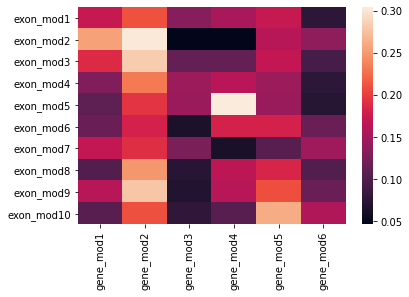

In [276]:
sns.heatmap(modules_df)